# Whale Classifier

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import dill as pickle

In [3]:
PATH = './data/whale/'
arch = resnet34
sz = 224
bs = 64

In [4]:
label_csv = f'{PATH}train.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n, val_pct=0.1)

In [5]:
# train_df = pd.read_csv(label_csv)
# train_df['Id'] = train_df['Id'].astype('category')
# whale_ids = train_df['Id'].unique()
# whale_ids2num = {k: v for k,v in zip(whale_ids, range(len(whale_ids)))}
# train_df['Id'] = train_df['Id'].map(whale_ids2num)
# train_df.to_csv(label_csv, index=False)
# pickle.dump(whale_ids2num, open('whale_ids2num.pkl', 'wb'))

In [6]:
# Define the MPA@5 metric
def mpa_at_k(probs, y, k):
    probs_sorted = np.argsort(-probs,axis=1)[:,:k] # Only interested in the top 5
    matches = np.array([a == b for a,b in zip(probs_sorted,y)])
    return np.sum(matches * np.array([[1.0/x for x in range(1,k+1)]])) / len(y)

def mpa_at_5(probs, y):
    return mpa_at_k(probs, y, 5)

def mpa_at_5_pyt(probs, y):
    probs = probs.cpu().numpy()
    return mpa_at_5(probs, y)

# Data Transform

In [7]:
def get_data(sz, bs, val):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)
    data = ImageClassifierData.from_csv(PATH, 'train', label_csv, test_name='test',
                                        val_idxs=val, tfms=tfms, bs=bs)
    return data

# Find Learning Rate

In [8]:
data = get_data(sz,bs,val_idxs)

In [9]:
learn = ConvLearner.pretrained(arch, data, ps=0.6)

In [10]:
lrf = learn.lr_find()

 94%|█████████▍| 131/139 [01:07<00:04,  1.93it/s, loss=19.5]

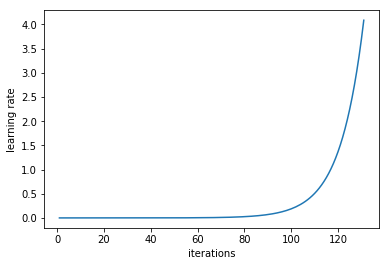

In [11]:
learn.sched.plot_lr()

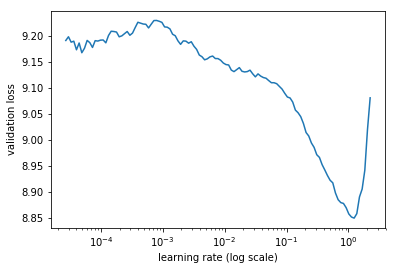

In [12]:
learn.sched.plot()

In [13]:
lr = 0.3

In [14]:
lrs = np.array([lr/100,lr/10,lr])

# Improve Model

In [15]:
learn.fit(lr, 3, metrics=[mpa_at_5_pyt])

epoch      trn_loss   val_loss   mpa_at_5_pyt               
    0      8.104665   7.715971   0.082657  
    1      7.695384   7.449004   0.097868                   
    2      7.334699   7.35739    0.064146                   


[array([7.35739]), 0.06414551607445007]

In [16]:
learn.precompute = False

In [17]:
learn.fit(lr, 3, cycle_len=1, metrics=[mpa_at_5_pyt])

epoch      trn_loss   val_loss   mpa_at_5_pyt               
    0      6.443407   6.92627    0.13357   
    1      6.205005   6.847105   0.147039                   
    2      5.861594   6.77902    0.148968                   


[array([6.77902]), 0.14896785109983082]

In [18]:
learn.save('resnet34_224_lastlayer9')

In [19]:
learn.load('resnet34_224_lastlayer9')

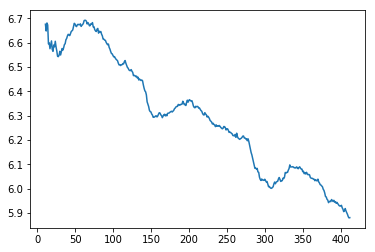

In [20]:
learn.sched.plot_loss()

In [21]:
learn.unfreeze()

In [22]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2, metrics=[mpa_at_5_pyt])

epoch      trn_loss   val_loss   mpa_at_5_pyt               
    0      6.440375   6.862585   0.131743  
    1      6.35264    6.755913   0.126684                   
    2      5.1833     6.513364   0.180592                   
    3      5.984138   6.846865   0.124992                   
    4      5.221113   6.414158   0.195398                   
    5      4.114211   6.232624   0.246717                   
    6      3.395273   6.278275   0.268257                   


[array([6.27828]), 0.2682571912013536]

In [23]:
learn.save('resnet34_224_all9')

In [24]:
learn.load('resnet34_224_all9')

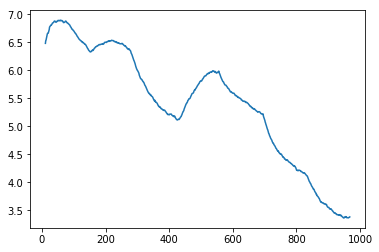

In [25]:
learn.sched.plot_loss()

# Increase Data Image Size

In [26]:
sz = 480

In [27]:
data = get_data(sz,bs,val_idxs)
learn.set_data(data)

In [28]:
learn.freeze()

In [29]:
learn.fit(lr, 3, cycle_len=1, metrics=[mpa_at_5_pyt])

epoch      trn_loss   val_loss   mpa_at_5_pyt               
    0      4.963554   6.53165    0.195313  
    1      4.695025   6.454573   0.22445                    
    2      4.382431   6.517207   0.225838                   


[array([6.51721]), 0.22583756345177664]

In [30]:
learn.save('resnet34_480_last_layer9')

In [31]:
learn.load('resnet34_480_last_layer9')

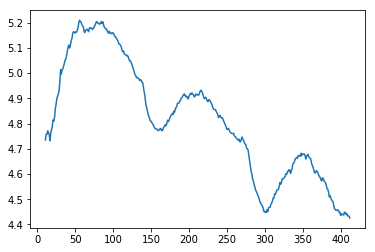

In [32]:
learn.sched.plot_loss()

In [33]:
learn.unfreeze()

In [ ]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2, metrics=[mpa_at_5_pyt])

epoch      trn_loss   val_loss   mpa_at_5_pyt               
    0      4.072757   6.363093   0.256667  
    1      4.556086   6.516928   0.235787                   
    2      3.017931   6.43412    0.297056                   
    3      4.524097   6.724152   0.225973                   
    4      3.811098   6.44346    0.273418                   
    5      2.592957   6.481549   0.327716                   
 87%|████████▋ | 121/139 [08:26<01:15,  4.19s/it, loss=1.9] 

In [ ]:
learn.save('resnet34_480_all9')

In [ ]:
learn.load('resnet34_480_all9')

In [ ]:
learn.sched.plot_loss()

# Train with Everything

In [ ]:
# Move all validation data except one (due to fastai limitation) to training data
data = get_data(sz,bs,[0])
learn.set_data(data)

In [39]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                   
    0      2.973442   13.770863  0.0       
  2%|▏         | 3/154 [00:12<10:29,  4.17s/it, loss=2.93]

KeyboardInterrupt: 

In [ ]:
learn.save('resnet34_480_all9_no_val_cyclce_mult2')

In [ ]:
learn.load('resnet34_480_all9_no_val_cyclce_mult2')

In [ ]:
learn.sched.plot_loss()

In [ ]:
learn.fit(lrs, 4, cycle_len=1, cycle_mult=2)

In [ ]:
learn.sched.plot_loss()

# Create Submission

In [ ]:
probs, _ = learn.TTA(is_test=True)

In [ ]:
# Assemble our data frame
mean_probs = np.mean(probs, axis=0) # Average probs from TTA
probs_sorted = np.argsort(-mean_probs,axis=1)[:,:5] # Get top 5 predictions

In [ ]:
import dill as pickle
whale_ids2num = pickle.load(open('whale_ids2num.pkl', 'rb'))

In [ ]:
fnames = [f[5:] for f in data.test_ds.fnames] # get rid of folder prefix

num2whale = [k for k,v in whale_ids2num.items()]

def probs2whale(x):
    return num2whale[int(data.classes[x])]

probs2whale = np.vectorize(probs2whale)

def join_with_spaces(arr):
    return ' '.join(arr)

whales = np.apply_along_axis(join_with_spaces, 1, probs2whale(probs_sorted))

In [ ]:
df = pd.DataFrame({'Image': fnames, 'Id': whales}, columns=['Image','Id'])
df.to_csv('submission9.csv', index=False)

In [ ]:
!kaggle competitions submit -c whale-categorization-playground -f submission9.csv -m "9th, transforms_side_on, 480px  training with 100% data, lr/100,lr/10,lr"

Kaggle Score: 0.46999 (8 using transforms_side_on, training with 100% data, lr/100,lr/10,lr, image size 480)